# 7주차: 의사결정트리 전체 파이프라인
### 📊 Breast Cancer 데이터 — 종양 특성 → 악성(malignant) / 양성(benign) 예측

---

**학습 목표**

| 차시 | 핵심 내용 |
|:----:|----------|
| 1 | 의사결정트리 원리, 지니 불순도(Gini Impurity) 직접 계산 |
| 2 | `max_depth` 하이퍼파라미터 튜닝, 과적합/과소적합 진단 |
| 3 | 트리 시각화, if-then 규칙 추출, 피처 중요도, 예측 경로 추적 |

**핵심 개념 요약**
- 의사결정트리 = **질문 반복 → 데이터 분할 → 다수결 예측**
- 분할 기준: 지니 불순도 — 노드가 얼마나 순수한가 (0.0 = 순수, 0.5 = 최대 불순)
- `max_depth` ↑(깊음): 복잡, 과적합 위험 · `max_depth` ↓(얕음): 단순, 과소적합 위험

---
## Step 1. 환경 설정 및 라이브러리 임포트

In [1]:
"""7주차 의사결정트리 실습 — 환경 설정."""

from __future__ import annotations

import warnings

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree

# -- Colab / Matplotlib 환경 설정 ------------------------------------------
warnings.filterwarnings("ignore", category=FutureWarning)
plt.rcParams.update({
    "figure.dpi": 120,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.facecolor": "white",
})

# -- 전역 상수 ----------------------------------------------------------------
RANDOM_STATE: int = 42
TEST_SIZE: float = 0.3
CV_FOLDS: int = 5
OVERFIT_GAP_THRESHOLD: float = 0.05

print("✅ 라이브러리 및 환경 설정 완료")

✅ 라이브러리 및 환경 설정 완료


---
## Step 2. 데이터 로드 및 탐색 (차시 1)
- **데이터**: `sklearn.datasets.load_breast_cancer` (별도 CSV 불필요)
- **피처 (30개)**: 종양의 반경, 질감, 둘레, 면적, 매끄러움 등
- **타겟**: `0 = malignant (악성)` · `1 = benign (양성)` — 이진 분류

In [2]:
"""Breast Cancer 데이터셋 로드 및 기본 정보 출력."""

dataset = load_breast_cancer()

print(f"데이터 shape : {dataset.data.shape}")
print(f"피처 수      : {len(dataset.feature_names)}개")
print(f"클래스       : {list(dataset.target_names)}")

데이터 shape : (569, 30)
피처 수      : 30개
클래스       : [np.str_('malignant'), np.str_('benign')]


In [3]:
"""클래스(타겟) 분포 확인."""

unique_labels, label_counts = np.unique(dataset.target, return_counts=True)

print("=== 타겟 분포 ===")
for name, count in zip(dataset.target_names, label_counts):
    ratio = count / len(dataset.target) * 100
    print(f"  {name:>10s}: {count:>3d}개  ({ratio:.1f}%)")

=== 타겟 분포 ===
   malignant: 212개  (37.3%)
      benign: 357개  (62.7%)


---
## Step 3. 지니 불순도 직접 계산 (차시 1)

의사결정트리는 **지니 불순도(Gini Impurity)** 가 가장 작아지는 방향으로 분할합니다.

$$\text{Gini} = 1 - p_1^2 - p_0^2$$

| 상황 | Gini 값 | 의미 |
|------|---------|------|
| 한 클래스만 존재 | 0.0 | 완전히 순수 |
| 이진 분류 반반 | 0.5 | 최대 불순 |
| 치우침 있음 | 0 ~ 0.5 | 부분적으로 순수 |

In [4]:
def compute_gini(n_positive: int, n_negative: int) -> float:
    """이진 분류 노드의 지니 불순도를 계산한다.

    Args:
        n_positive: 양성 클래스의 샘플 수.
        n_negative: 음성 클래스의 샘플 수.

    Returns:
        지니 불순도 값 (0.0 ~ 0.5).

    Raises:
        ValueError: n_positive 또는 n_negative가 음수일 때.
    """
    if n_positive < 0 or n_negative < 0:
        raise ValueError(
            f"샘플 수는 음수가 될 수 없습니다: "
            f"positive={n_positive}, negative={n_negative}"
        )
    total = n_positive + n_negative
    if total == 0:
        return 0.0
    p_pos = n_positive / total
    p_neg = n_negative / total
    return 1.0 - p_pos**2 - p_neg**2


def compute_weighted_gini(
    left_pos: int,
    left_neg: int,
    right_pos: int,
    right_neg: int,
) -> float:
    """분할 후 두 자식 노드의 가중 평균 지니 불순도를 계산한다.

    Args:
        left_pos: 왼쪽 자식 노드의 양성 샘플 수.
        left_neg: 왼쪽 자식 노드의 음성 샘플 수.
        right_pos: 오른쪽 자식 노드의 양성 샘플 수.
        right_neg: 오른쪽 자식 노드의 음성 샘플 수.

    Returns:
        가중 평균 지니 불순도 값.
    """
    left_total = left_pos + left_neg
    right_total = right_pos + right_neg
    total = left_total + right_total
    if total == 0:
        return 0.0
    gini_left = compute_gini(left_pos, left_neg)
    gini_right = compute_gini(right_pos, right_neg)
    return (left_total / total) * gini_left + (right_total / total) * gini_right

In [5]:
"""세 가지 상황에서 지니 불순도 직접 계산."""

GINI_CASES = [
    ("완전 순수   (악성 5, 양성 0)", 5, 0),
    ("최대 불순   (악성 5, 양성 5)", 5, 5),
    ("약간 치우침 (악성 8, 양성 2)", 8, 2),
]

print("=== 지니 불순도 계산 ===")
for label, n_pos, n_neg in GINI_CASES:
    print(f"  {label}  →  Gini = {compute_gini(n_pos, n_neg):.4f}")

=== 지니 불순도 계산 ===
  완전 순수   (악성 5, 양성 0)  →  Gini = 0.0000
  최대 불순   (악성 5, 양성 5)  →  Gini = 0.5000
  약간 치우침 (악성 8, 양성 2)  →  Gini = 0.3200


In [6]:
"""분할 후보별 가중 지니 비교 — 어느 분할이 더 좋은가?"""

SPLIT_CANDIDATES = [
    ("후보 A (내신 ≤ 4등급)", 4, 0, 1, 5),
    ("후보 B (내신 ≤ 5등급)", 5, 1, 0, 4),
    ("후보 C (모의 > 55%)  ", 5, 0, 0, 5),
]

print("=== 분할 후보 가중 Gini 비교 ===")
best_gini = float("inf")
best_label = ""

for label, lp, ln, rp, rn in SPLIT_CANDIDATES:
    gini = compute_weighted_gini(lp, ln, rp, rn)
    if gini < best_gini:
        best_gini, best_label = gini, label
    print(f"  {label}  →  Gini = {gini:.4f}")

print(f"\n  → 최적 분할: {best_label.strip()} (Gini = {best_gini:.4f})")

=== 분할 후보 가중 Gini 비교 ===
  후보 A (내신 ≤ 4등급)  →  Gini = 0.1667
  후보 B (내신 ≤ 5등급)  →  Gini = 0.1667
  후보 C (모의 > 55%)    →  Gini = 0.0000

  → 최적 분할: 후보 C (모의 > 55%) (Gini = 0.0000)


---
## Step 4–5. 피처/타겟 분리 및 훈련·테스트 분할
- `test_size=0.3` → 전체의 30%를 테스트로 분리
- `random_state=42` → 재현성(reproducibility) 보장

**왜 나누는가?** → 모델의 **일반화 성능**(새 데이터에서의 진짜 실력)을 측정하기 위해

In [7]:
"""피처/타겟 분리 후 훈련·테스트 세트 생성."""

X = dataset.data          # (569, 30) — 30개 종양 측정값
y = dataset.target        # (569,)    — 0: malignant, 1: benign

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

print(f"피처 shape   : {X.shape}")
print(f"타겟 클래스  : {{0: '{dataset.target_names[0]}', 1: '{dataset.target_names[1]}'}}")
print(f"훈련 세트    : {X_train.shape[0]}개")
print(f"테스트 세트  : {X_test.shape[0]}개")

피처 shape   : (569, 30)
타겟 클래스  : {0: 'malignant', 1: 'benign'}
훈련 세트    : 398개
테스트 세트  : 171개


---
## Step 6. 제한 없는 트리 — 학습 · 예측 (차시 2)
- `max_depth=None` (sklearn 기본값) → **제한 없이 끝까지 성장**
- `fit()` → 지니 불순도가 최소가 되는 분할을 반복

⚠ **주의**: `max_depth=None`은 '안전한 기본값'이 아니라 '제한 없음'을 의미

In [8]:
"""제한 없는 트리(max_depth=None) 학습 및 성능 확인."""

tree_default = DecisionTreeClassifier(random_state=RANDOM_STATE)
tree_default.fit(X_train, y_train)

print(f"테스트 정확도 (max_depth=None): {tree_default.score(X_test, y_test):.4f}")
print(f"실제 트리 깊이 : {tree_default.get_depth()}")
print(f"리프 노드 수   : {tree_default.get_n_leaves()}")

테스트 정확도 (max_depth=None): 0.9415
실제 트리 깊이 : 7
리프 노드 수   : 16


---
## Step 7. 훈련 정확도 vs 교차검증 정확도 비교 (차시 2)

| 패턴 | 훈련 | 교차검증 | 진단 |
|------|------|----------|------|
| 양호 | 높음 | 높음 | ✓ |
| 과적합 | 높음 | 낮음 | ⚠ |
| 과소적합 | 낮음 | 낮음 | ✗ |

In [9]:
"""제한 없는 트리의 훈련 정확도와 교차검증 정확도 비교."""

train_acc_default = tree_default.score(X_train, y_train)
cv_acc_default = cross_val_score(
    tree_default, X, y, cv=CV_FOLDS,
).mean()
gap_default = train_acc_default - cv_acc_default

print(f"훈련 정확도    : {train_acc_default:.4f}")
print(f"교차검증 정확도: {cv_acc_default:.4f}")
print(f"차이 (gap)     : {gap_default:.4f}")
print(f"진단           : {'⚠ 과적합 의심' if gap_default > OVERFIT_GAP_THRESHOLD else '✓ 양호'}")

훈련 정확도    : 1.0000
교차검증 정확도: 0.9173
차이 (gap)     : 0.0827
진단           : ⚠ 과적합 의심


---
## Step 8. 여러 max_depth 값 실험 (차시 2)
- 동일한 훈련/테스트 분리에서 `max_depth`만 변경 → **공정한 비교**

**k-NN과 방향 비교**

| 하이퍼파라미터 | 작을 때 | 클 때 |
|--------------|---------|-------|
| k-NN의 k | 복잡 → 과적합 | 단순 → 과소적합 |
| 트리의 max_depth | 단순 → 과소적합 | 복잡 → 과적합 |

In [10]:
"""대표 max_depth 6개 값으로 훈련/CV 정확도 비교."""


def evaluate_tree(
    max_depth: int | None,
    X_tr: np.ndarray,
    y_tr: np.ndarray,
    X_full: np.ndarray,
    y_full: np.ndarray,
) -> tuple[float, float]:
    """주어진 max_depth로 트리를 학습하고 훈련/CV 정확도를 반환한다.

    Args:
        max_depth: 트리의 최대 깊이 (None이면 제한 없음).
        X_tr: 훈련 피처.
        y_tr: 훈련 타겟.
        X_full: 전체 피처 (교차검증용).
        y_full: 전체 타겟 (교차검증용).

    Returns:
        (훈련 정확도, 교차검증 평균 정확도) 튜플.
    """
    tree = DecisionTreeClassifier(
        max_depth=max_depth, random_state=RANDOM_STATE,
    )
    tree.fit(X_tr, y_tr)
    train_acc = tree.score(X_tr, y_tr)
    cv_acc = cross_val_score(tree, X_full, y_full, cv=CV_FOLDS).mean()
    return train_acc, cv_acc


DEPTH_SAMPLES: list[int | None] = [1, 2, 3, 5, 10, None]

print(f"{'max_depth':>10} | {'훈련 정확도':>10} | {'CV 정확도':>10} | {'gap':>6} | 진단")
print("-" * 65)

for depth in DEPTH_SAMPLES:
    train_acc, cv_acc = evaluate_tree(depth, X_train, y_train, X, y)
    gap = train_acc - cv_acc
    status = "⚠ 과적합" if gap > OVERFIT_GAP_THRESHOLD else ""
    label = str(depth) if depth is not None else "None"
    print(f"{label:>10} | {train_acc:>10.4f} | {cv_acc:>10.4f} | {gap:>6.4f} | {status}")

 max_depth |     훈련 정확도 |     CV 정확도 |    gap | 진단
-----------------------------------------------------------------
         1 |     0.9246 |     0.8998 | 0.0248 | 
         2 |     0.9422 |     0.9280 | 0.0142 | 
         3 |     0.9698 |     0.9191 | 0.0507 | ⚠ 과적합
         5 |     0.9950 |     0.9191 | 0.0758 | ⚠ 과적합
        10 |     1.0000 |     0.9173 | 0.0827 | ⚠ 과적합
      None |     1.0000 |     0.9173 | 0.0827 | ⚠ 과적합


---
## Step 9–10. max_depth 체계적 실험 1~15 + 시각화 (차시 2)
- 넓은 범위를 촘촘하게 실험하여 **과적합 전환점** 포착
- gap > 0.05 시 과적합 표시

### 그래프 해석 3구간
| 구간 | depth 범위 | 특징 | 진단 |
|:----:|-----------|------|------|
| A | depth 작음 | 훈련↓ CV↓ — 둘 다 낮음 | 과소적합 |
| B | depth 적절 | 둘 다 높고 gap 작음 | 양호 (sweet spot) |
| C | depth 큼 | 훈련↑ CV↓ — gap 큼 | 과적합 |

In [11]:
"""max_depth 1~15 체계적 실험 및 시각화."""

DEPTH_RANGE = range(1, 16)
train_accuracies: list[float] = []
cv_accuracies: list[float] = []

print(f"{'depth':>5} | {'훈련 정확도':>10} | {'CV 정확도':>10} | 상태")
print("-" * 50)

for depth in DEPTH_RANGE:
    train_acc, cv_acc = evaluate_tree(depth, X_train, y_train, X, y)
    train_accuracies.append(train_acc)
    cv_accuracies.append(cv_acc)

    gap = train_acc - cv_acc
    status = "⚠ 과적합" if gap > OVERFIT_GAP_THRESHOLD else ""
    print(f"{depth:>5} | {train_acc:>10.4f} | {cv_acc:>10.4f} | {status}")

depth |     훈련 정확도 |     CV 정확도 | 상태
--------------------------------------------------
    1 |     0.9246 |     0.8998 | 
    2 |     0.9422 |     0.9280 | 
    3 |     0.9698 |     0.9191 | ⚠ 과적합
    4 |     0.9950 |     0.9209 | ⚠ 과적합
    5 |     0.9950 |     0.9191 | ⚠ 과적합
    6 |     0.9975 |     0.9209 | ⚠ 과적합
    7 |     1.0000 |     0.9191 | ⚠ 과적합
    8 |     1.0000 |     0.9156 | ⚠ 과적합
    9 |     1.0000 |     0.9173 | ⚠ 과적합
   10 |     1.0000 |     0.9173 | ⚠ 과적합
   11 |     1.0000 |     0.9173 | ⚠ 과적합
   12 |     1.0000 |     0.9173 | ⚠ 과적합
   13 |     1.0000 |     0.9173 | ⚠ 과적합
   14 |     1.0000 |     0.9173 | ⚠ 과적합
   15 |     1.0000 |     0.9173 | ⚠ 과적합


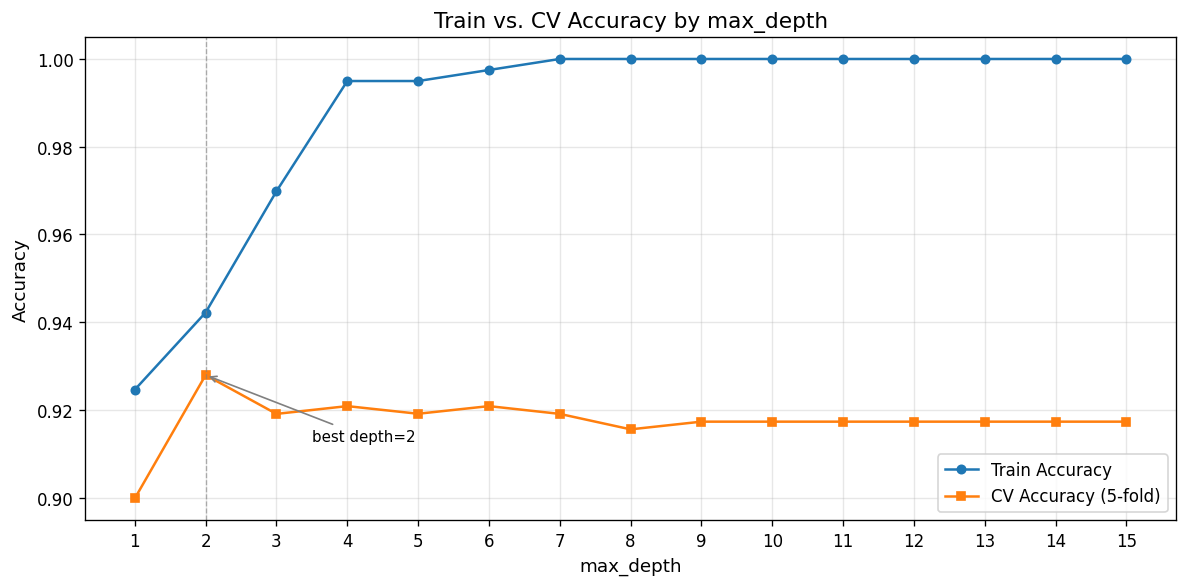

In [12]:
"""max_depth에 따른 훈련/CV 정확도 변화 그래프."""

depths = list(DEPTH_RANGE)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(depths, train_accuracies, marker="o", ms=5, label="Train Accuracy")
ax.plot(depths, cv_accuracies, marker="s", ms=5, label=f"CV Accuracy ({CV_FOLDS}-fold)")

# 최적 depth 강조
best_idx = int(np.argmax(cv_accuracies))
ax.axvline(depths[best_idx], color="grey", ls="--", lw=0.8, alpha=0.6)
ax.annotate(
    f"best depth={depths[best_idx]}",
    xy=(depths[best_idx], cv_accuracies[best_idx]),
    xytext=(depths[best_idx] + 1.5, cv_accuracies[best_idx] - 0.015),
    fontsize=9,
    arrowprops={"arrowstyle": "->", "color": "grey"},
)

ax.set_xlabel("max_depth")
ax.set_ylabel("Accuracy")
ax.set_title("Train vs. CV Accuracy by max_depth")
ax.set_xticks(depths)
ax.legend()
ax.grid(True, alpha=0.3)
fig.tight_layout()
plt.show()

---
## Step 11. 최적 max_depth 확인 (차시 2)

In [13]:
"""CV 정확도 기준 최적 max_depth 요약."""

best_depth = depths[best_idx]
best_cv = cv_accuracies[best_idx]
best_train = train_accuracies[best_idx]

print(f"CV 정확도 최고 max_depth : {best_depth}")
print(f"  훈련 정확도            : {best_train:.4f}")
print(f"  CV 정확도              : {best_cv:.4f}")
print(f"  차이 (gap)             : {best_train - best_cv:.4f}")
print()
print("⚠ 이 결과는 random_state=42의 단일 분할 결과입니다.")
print("  random_state를 바꾸면 최적 depth도 달라질 수 있으므로,")
print("  교차검증(Cross-Validation) 결과를 우선 신뢰하세요.")

CV 정확도 최고 max_depth : 2
  훈련 정확도            : 0.9422
  CV 정확도              : 0.9280
  차이 (gap)             : 0.0142

⚠ 이 결과는 random_state=42의 단일 분할 결과입니다.
  random_state를 바꾸면 최적 depth도 달라질 수 있으므로,
  교차검증(Cross-Validation) 결과를 우선 신뢰하세요.


---
## Step 12. 트리 시각화 — `plot_tree` (차시 3)

학습된 트리를 **눈으로 직접** 읽습니다. 각 노드는 5줄로 구성됩니다.

| 줄 | 내용 | 예시 |
|----|------|------|
| 1 | 분할 기준 | `worst radius <= 16.80` |
| 2 | 지니 불순도 | `gini = 0.468` |
| 3 | 샘플 수 | `samples = 569` |
| 4 | 클래스 분포 | `value = [212, 357]` |
| 5 | 다수 클래스 | `class = benign` |

**해석 포인트**: 루트에 가까울수록 중요한 피처 → `feature_importances_`와 일치

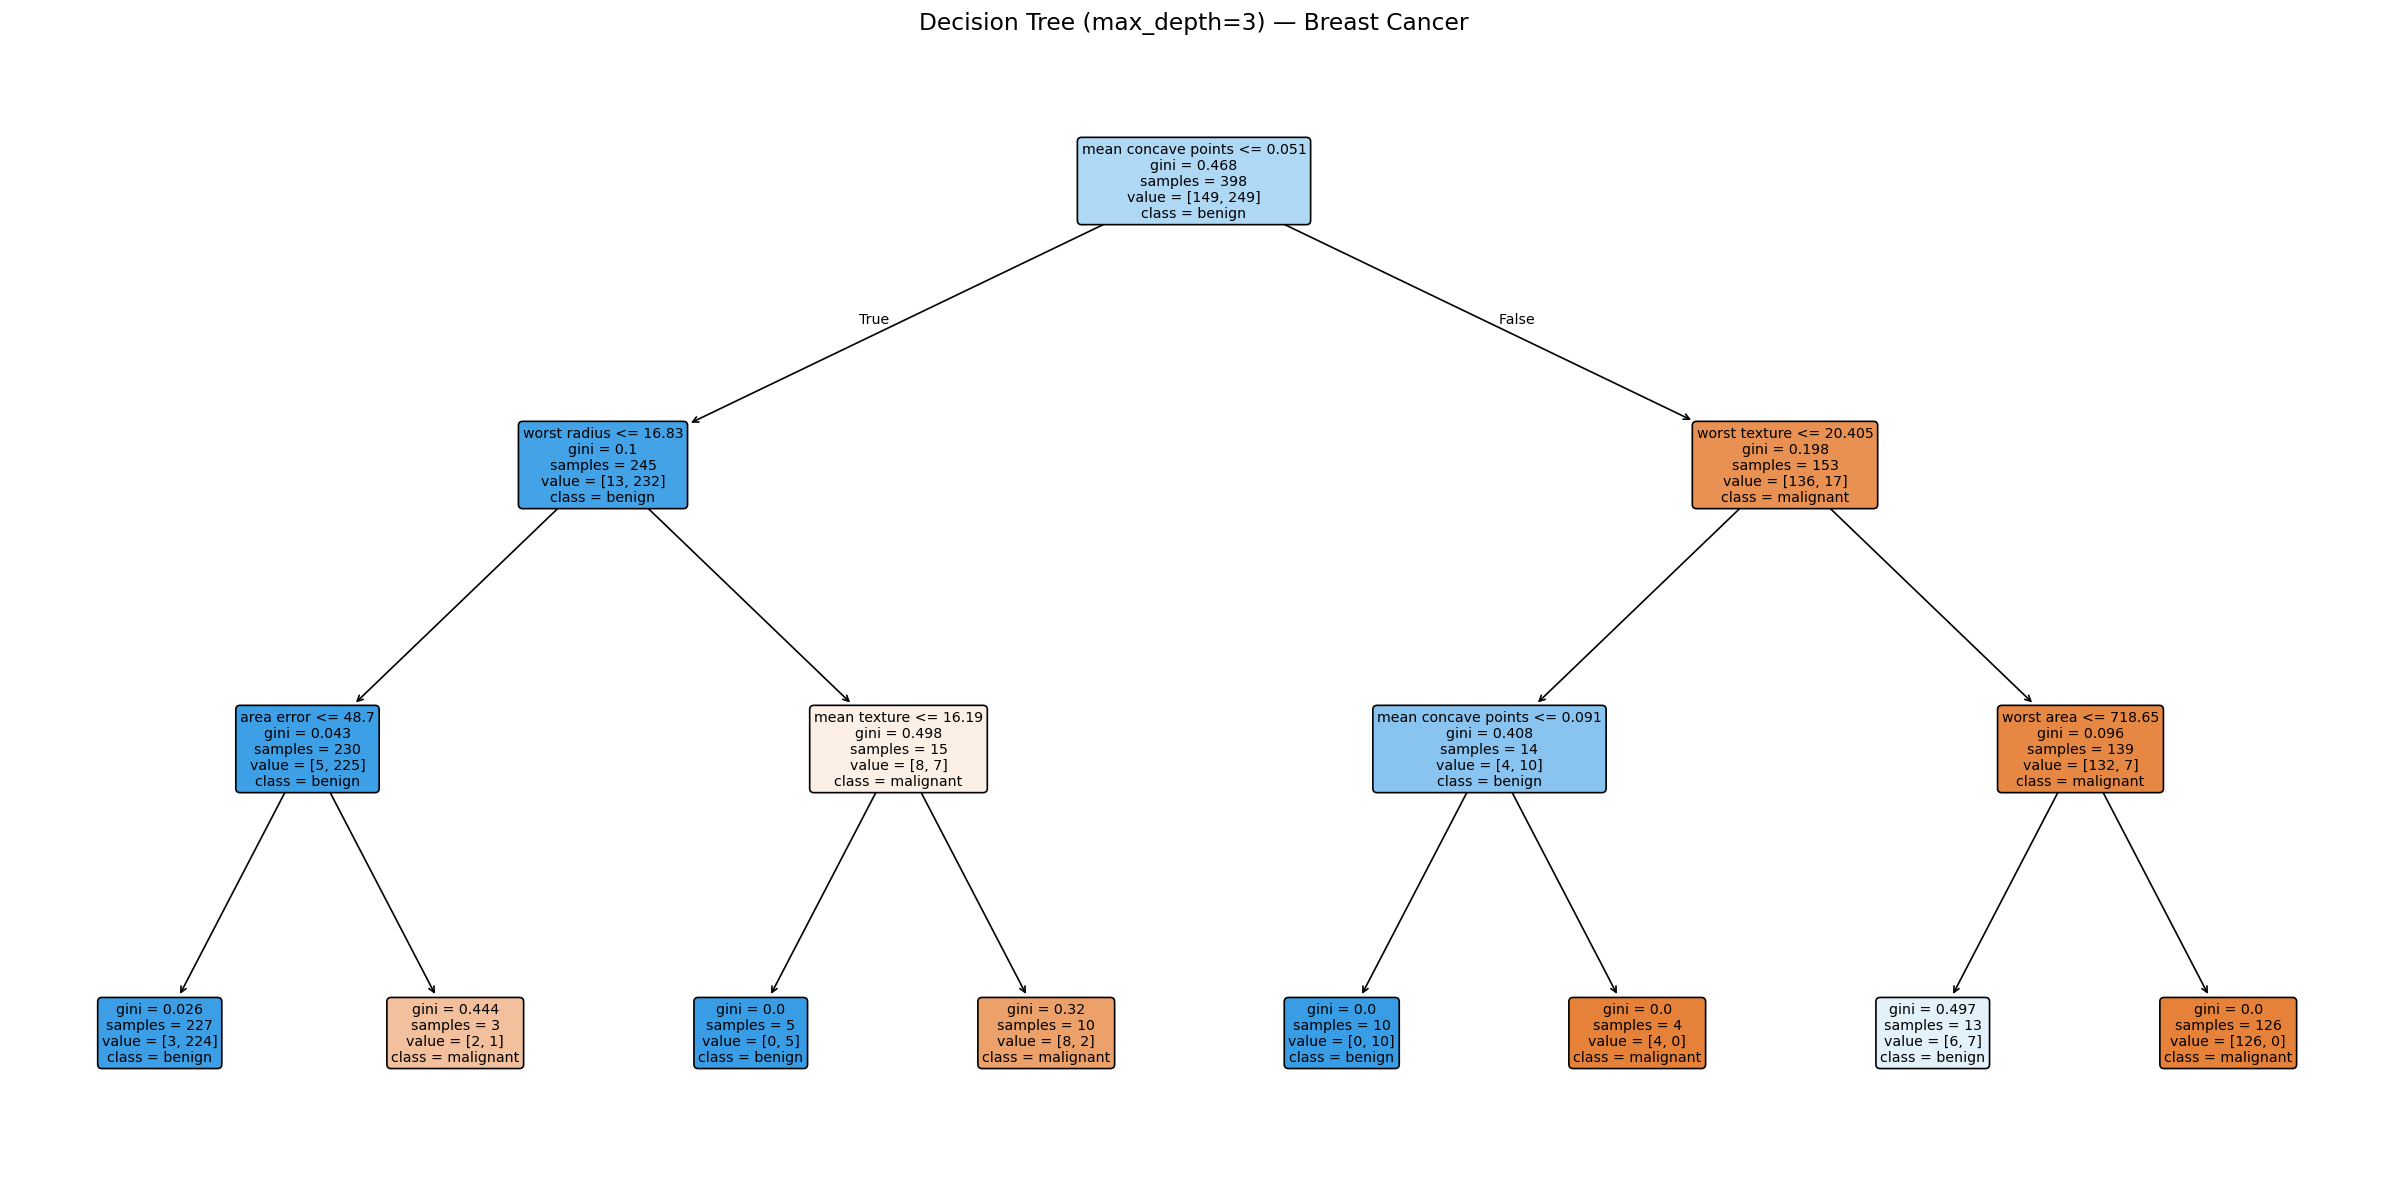

In [14]:
"""가지치기 트리(max_depth=3) 학습 및 시각화."""

INTERPRETABLE_DEPTH: int = 3

tree_pruned = DecisionTreeClassifier(
    max_depth=INTERPRETABLE_DEPTH, random_state=RANDOM_STATE,
)
tree_pruned.fit(X_train, y_train)

fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(
    tree_pruned,
    feature_names=dataset.feature_names,
    class_names=list(dataset.target_names),
    filled=True,
    rounded=True,
    ax=ax,
)
ax.set_title(
    f"Decision Tree (max_depth={INTERPRETABLE_DEPTH}) — Breast Cancer",
    fontsize=14,
)
fig.tight_layout()
plt.show()

---
## Step 13. if-then 규칙 — `export_text` (차시 3)

트리를 **텍스트 규칙**으로 변환합니다 (들여쓰기 = 트리 깊이).

예: `IF worst radius <= 16.80 AND worst concave pts <= 0.14 → class: benign`

로지스틱 회귀나 k-NN에서는 이런 **명시적 규칙 추출이 불가능**합니다.

In [15]:
"""트리를 텍스트 기반 if-then 규칙으로 출력."""

rules = export_text(
    tree_pruned,
    feature_names=list(dataset.feature_names),
    max_depth=INTERPRETABLE_DEPTH,
)
print(f"=== if-then 규칙 (max_depth={INTERPRETABLE_DEPTH}) ===")
print(rules)

=== if-then 규칙 (max_depth=3) ===
|--- mean concave points <= 0.05
|   |--- worst radius <= 16.83
|   |   |--- area error <= 48.70
|   |   |   |--- class: 1
|   |   |--- area error >  48.70
|   |   |   |--- class: 0
|   |--- worst radius >  16.83
|   |   |--- mean texture <= 16.19
|   |   |   |--- class: 1
|   |   |--- mean texture >  16.19
|   |   |   |--- class: 0
|--- mean concave points >  0.05
|   |--- worst texture <= 20.40
|   |   |--- mean concave points <= 0.09
|   |   |   |--- class: 1
|   |   |--- mean concave points >  0.09
|   |   |   |--- class: 0
|   |--- worst texture >  20.40
|   |   |--- worst area <= 718.65
|   |   |   |--- class: 1
|   |   |--- worst area >  718.65
|   |   |   |--- class: 0



---
## Step 14. 피처 중요도 — `feature_importances_` (차시 3)

각 피처가 분할에서 지니 불순도를 **얼마나 감소시켰는가**의 비율.

| 비교 항목 | 선형 회귀 계수 | 트리 피처 중요도 |
|----------|--------------|----------------|
| 의미 | 1 증가 시 예측 변화량 | 분할 기여 비율 |
| 부호(방향) | +/- 있음 | 없음 (0 ~ 1) |
| 합계 | 제한 없음 | 정확히 1.0 |

**포인트**: 루트에 가까운 피처 = 중요도 높음 (더 많은 데이터에 영향)

In [16]:
"""피처 중요도 텍스트 출력 (상위 10개)."""

TOP_N: int = 10

importances = tree_pruned.feature_importances_
feature_names = dataset.feature_names
sorted_idx = np.argsort(importances)[::-1]

print(f"=== 피처 중요도 (상위 {TOP_N}개) ===")
for rank, idx in enumerate(sorted_idx[:TOP_N], start=1):
    bar = "█" * int(importances[idx] * 50)
    print(f"{rank:>2}. {feature_names[idx]:>30s}  {importances[idx]:.4f}  {bar}")

print(f"\n  중요도 합계: {importances.sum():.4f} (정확히 1.0이어야 함)")

=== 피처 중요도 (상위 10개) ===
 1.            mean concave points  0.8100  ████████████████████████████████████████
 2.                  worst texture  0.0661  ███
 3.                   worst radius  0.0435  ██
 4.                     worst area  0.0403  ██
 5.                   mean texture  0.0252  █
 6.                     area error  0.0149  
 7.               worst smoothness  0.0000  
 8.              worst compactness  0.0000  
 9.                worst concavity  0.0000  
10.                worst perimeter  0.0000  

  중요도 합계: 1.0000 (정확히 1.0이어야 함)


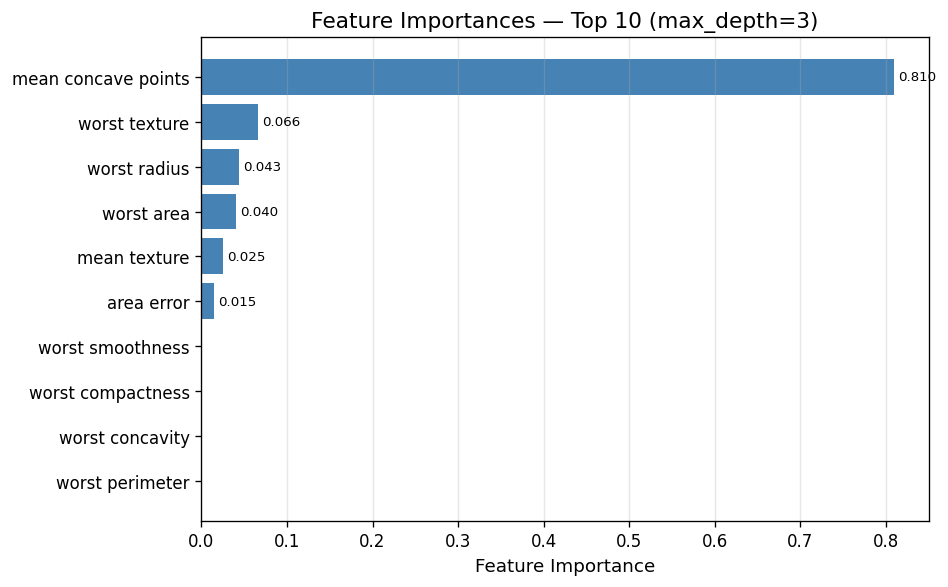

In [17]:
"""피처 중요도 가로 막대 그래프."""

top_idx = sorted_idx[:TOP_N]
top_names = [feature_names[i] for i in top_idx][::-1]   # 아래→위 순서
top_values = importances[top_idx][::-1]

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.barh(range(TOP_N), top_values, color="steelblue")

# 값 레이블 표시
for bar, val in zip(bars, top_values):
    if val > 0.005:  # 극소값은 레이블 생략
        ax.text(
            bar.get_width() + 0.005, bar.get_y() + bar.get_height() / 2,
            f"{val:.3f}", va="center", fontsize=8,
        )

ax.set_yticks(range(TOP_N))
ax.set_yticklabels(top_names)
ax.set_xlabel("Feature Importance")
ax.set_title(f"Feature Importances — Top {TOP_N} (max_depth={INTERPRETABLE_DEPTH})")
ax.grid(axis="x", alpha=0.3)
fig.tight_layout()
plt.show()

---
## Step 15. 예측 경로 추적 — `decision_path` (차시 3)

특정 샘플 1개에 대해 트리가 **루트 → 리프까지 어떤 경로를 거쳤는지** 추적합니다.

"이 종양은 `worst radius > 16.80`이고 … 이므로 악성(malignant)으로 분류"
→ 로지스틱 회귀나 k-NN보다 훨씬 **직관적인 해석 가능성**

In [18]:
def trace_decision_path(
    tree: DecisionTreeClassifier,
    X_data: np.ndarray,
    y_data: np.ndarray,
    sample_index: int,
    feature_names: np.ndarray,
    target_names: np.ndarray,
) -> None:
    """특정 샘플의 의사결정 경로를 추적하여 출력한다.

    Args:
        tree: 학습된 DecisionTreeClassifier.
        X_data: 전체 피처 배열.
        y_data: 전체 타겟 배열.
        sample_index: 추적할 샘플의 인덱스.
        feature_names: 피처 이름 배열.
        target_names: 타겟 클래스 이름 배열.
    """
    sample = X_data[sample_index].reshape(1, -1)
    node_indicator = tree.decision_path(sample)
    predicted = tree.predict(sample)[0]
    actual = y_data[sample_index]

    match_str = "✓ 정답" if predicted == actual else "✗ 오답"

    print(f"=== 예측 경로 추적 (샘플 #{sample_index}) ===")
    print(f"실제 클래스: {target_names[actual]}")
    print(f"예측 클래스: {target_names[predicted]}  ({match_str})")
    print()
    print("경로 단계별 분기 조건:")

    tree_struct = tree.tree_
    for step, node_id in enumerate(node_indicator.indices, start=1):
        feat_idx = tree_struct.feature[node_id]

        # 리프 노드: feature index == TREE_UNDEFINED (-2)
        if feat_idx < 0:
            print(f"  Step {step}: → 리프 노드 도달 (예측 완료)")
            continue

        feat_name = feature_names[feat_idx]
        threshold = tree_struct.threshold[node_id]
        actual_val = X_data[sample_index, feat_idx]
        direction = "≤ (왼쪽)" if actual_val <= threshold else ">  (오른쪽)"

        print(
            f"  Step {step}: 노드 {node_id:>2d} | "
            f"{feat_name:>30s} = {actual_val:>8.3f}  "
            f"(기준 {threshold:>8.3f})  → {direction}"
        )

In [19]:
"""샘플 0번의 예측 경로 추적 데모."""

trace_decision_path(
    tree=tree_pruned,
    X_data=X,
    y_data=y,
    sample_index=0,
    feature_names=dataset.feature_names,
    target_names=dataset.target_names,
)

=== 예측 경로 추적 (샘플 #0) ===
실제 클래스: malignant
예측 클래스: malignant  (✓ 정답)

경로 단계별 분기 조건:
  Step 1: 노드  0 |            mean concave points =    0.147  (기준    0.051)  → >  (오른쪽)
  Step 2: 노드  8 |                  worst texture =   17.330  (기준   20.405)  → ≤ (왼쪽)
  Step 3: 노드  9 |            mean concave points =    0.147  (기준    0.091)  → >  (오른쪽)
  Step 4: → 리프 노드 도달 (예측 완료)


---
## 📝 전체 요약

| Step | 내용 | 핵심 포인트 |
|:----:|------|------------|
| 1–2 | 데이터 로드 · 탐색 | Breast Cancer 569건, 30피처, 이진 분류 |
| 3 | 지니 불순도 직접 계산 | 0.0(순수) ~ 0.5(최대 불순) |
| 4–5 | 데이터 분리 | 70% 훈련, 30% 테스트 |
| 6–7 | 제한 없는 트리 | `max_depth=None` → 과적합 위험 확인 |
| 8–11 | max_depth 튜닝 | 체계적 실험 → 최적 depth 선택 |
| 12–13 | 트리 시각화 + 규칙 추출 | `plot_tree`, `export_text` |
| 14 | 피처 중요도 | `feature_importances_` — 지니 감소 기여 비율 |
| 15 | 예측 경로 추적 | `decision_path` — 개별 샘플 해석 가능 |